# Support Vector Machines 

In this second notebook on SVMs we will walk through the implementation of both the hard margin and soft margin SVM algorithm in Python using the well known CVXOPT library. While the algorithm in its mathematical form is rather straightfoward, its implementation in matrix form using the CVXOPT API can be challenging at first. This notebook will show the steps required to derive the appropriate vectorized notation as well as the inputs needed for the API.

### Background
This notebook assumes previous knowledge and understanding of the mathematics behind SVMs and the formulation of the primal / dual optimization problem. For a summary of this topic please have a look at the following post on stats.stackexchange:
- https://stats.stackexchange.com/questions/23391/how-does-a-support-vector-machine-svm-work/353605#353605

### Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

### The dataset and inspection 

We will use the same dataset as in the previous notebook of this series. In this case the data is linearly separable

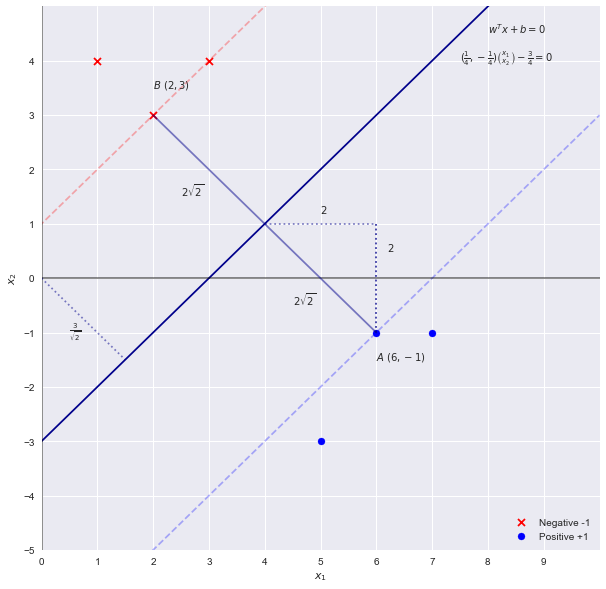

In [4]:
#Data set
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3]])
y_pos = np.array([1,1,1])
x1 = np.linspace(-10,10)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))

#Data for the next section
X = np.vstack((x_pos, x_neg))
y = np.concatenate((y_pos,y_neg))

#Parameters guessed by inspection
w = np.array([1,-1]).reshape(-1,1)
b = -3

#Plot
fig = plt.figure(figsize = (10,10))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue')
plt.plot(x1, x1  - 7, linestyle = '--', alpha = .3, color = 'b')
plt.plot(x1, x1  + 1, linestyle = '--', alpha = .3, color = 'r')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(-5, 5, step=1))

#Lines
plt.axvline(0, color = 'black', alpha = .5)
plt.axhline(0,color = 'black', alpha = .5)
plt.plot([2,6],[3,-1], linestyle = '-', color = 'darkblue', alpha = .5 )
plt.plot([4,6],[1,1],[6,6],[1,-1], linestyle = ':', color = 'darkblue', alpha = .5 )
plt.plot([0,1.5],[0,-1.5],[6,6],[1,-1], linestyle = ':', color = 'darkblue', alpha = .5 )

#Annotations
plt.annotate(s = '$A \ (6,-1)$', xy = (5,-1), xytext = (6,-1.5))
plt.annotate(s = '$B \ (2,3)$', xy = (2,3), xytext = (2,3.5))#, arrowprops = {'width':.2, 'headwidth':8})
plt.annotate(s = '$2$', xy = (5,1.2), xytext = (5,1.2) )
plt.annotate(s = '$2$', xy = (6.2,.5), xytext = (6.2,.5))
plt.annotate(s = '$2\sqrt{2}$', xy = (4.5,-.5), xytext = (4.5,-.5))
plt.annotate(s = '$2\sqrt{2}$', xy = (2.5,1.5), xytext = (2.5,1.5))
plt.annotate(s = '$w^Tx + b = 0$', xy = (8,4.5), xytext = (8,4.5))
plt.annotate(s = '$(\\frac{1}{4},-\\frac{1}{4}) \\binom{x_1}{x_2}- \\frac{3}{4} = 0$', xy = (7.5,4), xytext = (7.5,4))
plt.annotate(s = '$\\frac{3}{\sqrt{2}}$', xy = (.5,-1), xytext = (.5,-1))

#Labels and show
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc = 'lower right')
plt.show()

# Implementing the SVM algorithm (Hard margin)
## Case 1) Linearly separable, binary classification

Using the notation and steps provided by [Tristan Fletcher][1] the general steps to solve the SVM problem are the following: 


- Create $\mathbf{P}$ where $H_{i,j} = y^{(i)}y^{(j)} <x^{(i)} x^{(j)}> $
- Calculate $\mathbf{w} = \sum_i^m y^{(i)} \alpha_i x^{(i)}$
- Determine the set of support vectors $S$ by finding the indices such that $\alpha_i > 0$
- Calculate the intercept term using $b = y^{(s)} - \sum_{m \in S} \alpha_m  y^{(m)}  <x^{(m)}  x^{(s)} >$
- For each new point $x'$ classify according to $y' = sign(w^T x' + b)$

------------------

## Re-writing the problem in an appropriate format

Since we will solve this optimization problem using the **[CVXOPT][2]** library in python we will need to match the solver's API which, according to the documentation is of the form: 

\begin{aligned}
	& \min \frac{1}{2} x^TPx + q^Tx
	\\
	 s.t. \ & \ Gx \leq h 
	\\
	& \ Ax = b
\end{aligned}

With API


> ```cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])```


Recall that the dual problem is expressed as:

$$ \max_{\alpha} \sum_i^m \alpha_i - \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j <x^{(i)} x^{(j)}> $$

Let $\mathbf{H}$ be a matrix such that $H_{i,j} = y^{(i)}y^{(j)} <x^{(i)} x^{(j)}> $, then the optimization becomes:


\begin{aligned}
	& \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
	\\
	 s.t. & \ \alpha_i \geq 0 
	\\
	&  \ \sum_i^m \alpha_i y^{(i)} = 0	
\end{aligned}


We convert the sums into vector form and multiply both the objective and the constraint by $-1$ which turns this into a minimization problem and reverses the inequality 

\begin{aligned}
	& \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
	\\
	& s.t. \ - \alpha_i \leq 0 
	\\
	& s.t. \ y^T \alpha = 0	
\end{aligned}

 

We are now ready to convert our numpy arrays into the cvxopt format, using the same notation as in the documentation this gives

- $P := H$  a matrix of size $m \times m$ 
- $q := - \vec 1$ a vector of size $m \times 1$
- $G : = - diag[1]$ a diagonal matrix of -1s of size $m \times m$
- $h : = \vec 0$ a vector of zeros of size $m \times 1$ 
- $A := y$ the label vector of size $m \times 1$ 
- $b := 0$ a scalar

Note that in the simple example of $m = 2$ the matrix $G$ and vector $h$ which define the constraint are  


$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \end{bmatrix} $ and $h = \begin{bmatrix} 0 \\ 0  \end{bmatrix} $





[1]: https://static1.squarespace.com/static/58851af9ebbd1a30e98fb283/t/58902fbae4fcb5398aeb7505/1485844411772/SVM+Explained.pdf 
[2]: https://cvxopt.org/userguide/coneprog.html#quadratic-programming

## Computing the matrix $\mathbf{H}$ in vectorized form 

Consider the simple example with 2 input samples $\{x^{(1)}, x^{(2)}\} \in \mathbb{R}^2$ which are two dimensional vectors. i.e. $x^{(1)} = (x_1^{(1)} , x_2^{(1)})^T$

$$ X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \end{bmatrix} \ \ \ y = \begin{bmatrix} y^{(1)}  \\ y^{(2)} \end{bmatrix} $$

We now proceed to creating a new matrix $X'$ where each input sample $x$ is multiplied by the corresponding output label $y$. This can be done easily in Numpy using vectorization and padding. 

$$X' = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix} $$

Finally we take the **matrix multiplication** of $X'$ and its transpose giving $H = X'  X'^T$

$$H = X' @ X'^T = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix} \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(2)}_1 y^{(2)}  \\
x^{(1)}_2y^{(1)} & x^{(2)}_2y^{(2)} \end{bmatrix} $$

$$ H = \begin{bmatrix}  x^{(1)}_1 x^{(1)}_1y^{(1)}y^{(1)} + x^{(1)}_2x^{(1)}_2y^{(1)}y^{(1)} & x^{(1)}_1 x^{(2)}_1y^{(1)}y^{(2)} + x^{(1)}_2x^{(2)}_2y^{(1)}y^{(2)} \\ x^{(2)}_1 x^{(1)}_1y^{(2)}y^{(1)} + x^{(2)}_2x^{(1)}_2y^{(2)}y^{(1)} & x^{(2)}_1 x^{(2)}_1y^{(2)}y^{(2)} + x^{(2)}_2x^{(2)}_2y^{(2)}y^{(2)} \end{bmatrix}$$


## Implementation in Python
### CVXOPT solver and resulting $\alpha$ 

In [5]:
#Importing with custom names to avoid issues with numpy / sympy matrix
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

#Initializing values and computing H. Note the 1. to force to float type
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(-np.eye(m))
h = cvxopt_matrix(np.zeros(m))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

### Compute $w$ and $b$ parameters 

In [6]:
#w parameter in vectorized form
w = ((y * alphas).T @ X).reshape(-1,1)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b
b = y[S] - np.dot(X[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [0.0625     0.06249356]
w =  [ 0.24999356 -0.25000644]
b =  [-0.74996781]


# Implementing the SVM algorithm (Soft Margin)
## Adding a positive point in the middle of the negative cluster

The data is no longer linearly separable

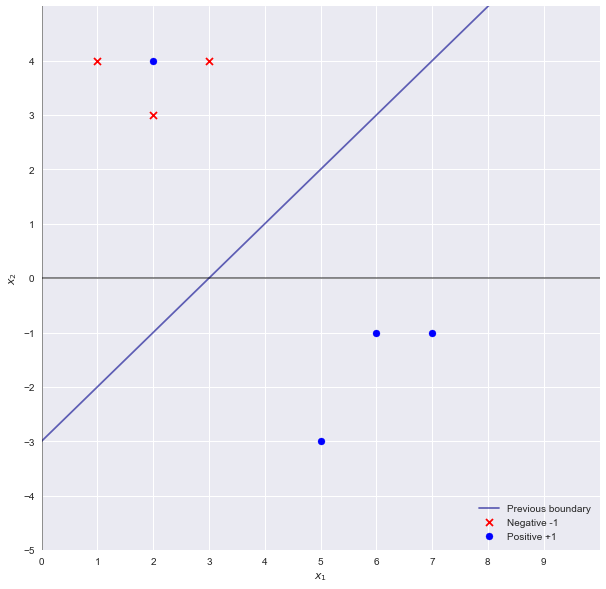

In [8]:
x_neg = np.array([[3,4],[1,4],[2,3]])
y_neg = np.array([-1,-1,-1])
x_pos = np.array([[6,-1],[7,-1],[5,-3],[2,4]])
y_pos = np.array([1,1,1,1])
x1 = np.linspace(-10,10)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))


fig = plt.figure(figsize = (10,10))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue', alpha = .6, label = 'Previous boundary')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(-5, 5, step=1))

#Lines
plt.axvline(0, color = 'black', alpha = .5)
plt.axhline(0,color = 'black', alpha = .5)


plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.legend(loc = 'lower right')
plt.show()

#New dataset (for later)
X = np.array([[3,4],[1,4],[2,3],[6,-1],[7,-1],[5,-3],[2,4]] )
y = np.array([-1,-1, -1, 1, 1 , 1, 1 ])

## Case 2) Non fully linearly separable, binary classification

For the softmax margin SVM, recall that the optimization problem can be expressed as

\begin{aligned}
	& \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
	\\
	 s.t. \ \ & 0 \leq \alpha_i \leq C 
	\\
	&  \ \sum_i^m \alpha_i y^{(i)} = 0	
\end{aligned}

Which can be written in standard form as 
\begin{aligned}
	& \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
	\\
	 s.t. & \ - \alpha_i \leq 0 
	\\
     & \alpha_i \leq C
     \\
	 &\ y^T \alpha = 0	
\end{aligned}

This is almost the same problem as previously, except for the additional inequality constraint on $\alpha$. We translate this new constraint into standard form by concatenating below matrix $G$ a diagonal matrix of 1s of size $m \times m$. Similarly for the vector $h$ to which the value of $C$ is added $m$ times. 

Note that in the simple example of $m = 2$ the matrix $G$ and vector $h$ which define the constraint are  


$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ 1 & 0 \\ 0 & 1\end{bmatrix} $ and $h = \begin{bmatrix} 0 \\ 0 \\ C \\ C \end{bmatrix} $



## CVXOPT Solver with the new constraint 

In [9]:
#Initializing values and computing H. Note the 1. to force to float type
C = 10
m,n = X.shape
y = y.reshape(-1,1) * 1.
X_dash = y * X
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format - as previously
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#==================Computing and printing parameters===============================#
w = ((y * alphas).T @ X).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [ 5.      6.3125  1.3125 10.    ]
w =  [ 0.25 -0.25]
b =  [-0.75]


## Comparing to Sklearn results 

In [10]:
clf = SVC(C = 10, kernel = 'linear')
clf.fit(X, y.ravel()) 

print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))


w =  [[ 0.25 -0.25]]
b =  [-0.75]
Indices of support vectors =  [0 2 3 6]
Support vectors =  [[ 3.  4.]
 [ 2.  3.]
 [ 6. -1.]
 [ 2.  4.]]
Number of support vectors for each class =  [2 2]
Coefficients of the support vector in the decision function =  [[ 5.      6.3125  1.3125 10.    ]]


# Sources and further reading
https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/

http://goelhardik.github.io/2016/11/28/svm-cvxopt/

https://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.coneqp
